In [2]:
import numpy as np
import pandas as pd
from arch import arch_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
dataset = pd.read_csv('data/bitcoin/bitcoin_preprocessed.csv', parse_dates=['Date'], index_col = "Date")
dataset_garch = dataset.copy()
dataset_garch['Returns'] = (np.log(dataset_garch['Close'] / dataset_garch['Close'].shift(1))) *100
dataset_garch.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %', 'Average'], inplace=True)


KeyError: 'Price'

In [149]:
dataset_garch.fillna(method='bfill', inplace = True)
dataset_garch

C:\Users\Wiola\AppData\Local\Temp\ipykernel_6460\4150309887.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset_garch.fillna(method='bfill', inplace = True)


,Price,Returns
Date,,
2010-07-18,0.1,0.000000
2010-07-19,0.1,0.000000
2010-07-20,0.1,0.000000
2010-07-21,0.1,0.000000
2010-07-22,0.1,0.000000
...,...,...
2024-12-28,95284.5,1.064156
2024-12-29,93716.3,-1.659502
2024-12-30,92779.8,-1.004319


In [159]:
tstart = "2016-01-01"
tend = "2022-02-10"

In [160]:
def train_test_split_garch(dataset, tstart, tend):
    tend_next = pd.to_datetime(tend) + pd.Timedelta(days=1)

    train = dataset_garch.loc[tstart:tend, "Returns"].values
    test = dataset_garch.loc[tend_next:, "Returns"].values
    return train, test

training_set_garch, test_set_garch = train_test_split_garch(dataset_garch, tstart, tend)



In [170]:
p_values = [1, 2, 3]
q_values = [1, 2, 3]

best_aic = np.inf
best_bic = np.inf
best_model = None
best_p, best_q = None, None

for p in p_values:
    for q in q_values:
        try:
            model = arch_model(dataset_garch['Returns'], vol='Garch', p=p, q=q, mean='Constant')
            model_fit = model.fit(disp='off')
            
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_bic = model_fit.bic
                best_model = model_fit
                best_p, best_q = p, q

        except Exception as e:
            print(f"Error fitting GARCH({p},{q}): {e}")

print(f"Best Model: GARCH({best_p},{best_q})")
print(f"AIC: {best_aic}")
print(f"BIC: {best_bic}")

Best Model: GARCH(3,3)
AIC: 30184.353796688985
BIC: 30236.930277431842


In [171]:
model = arch_model(training_set_garch, vol='Garch', p=3, q=3, mean='Constant', dist='normal')
fit = model.fit(disp="off")

In [172]:
horizon = len(test_set_garch)
forecast = fit.forecast(horizon=horizon, reindex=False)
forecasted_volatility = np.sqrt(forecast.variance.values[-1])

actual_volatility = test_set_garch**2  # Use squared returns as a proxy for realized variance
mse = mean_squared_error(actual_volatility, forecasted_volatility**2)  # Compare variances
print(f"Mean Squared Error (MSE): {mse}")


Mean Squared Error (MSE): 942.978496785249


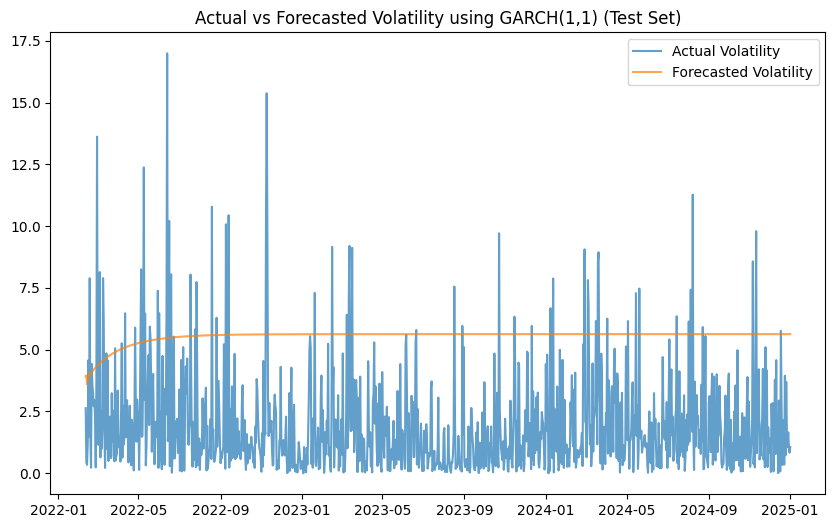

In [173]:
plt.figure(figsize=(10, 6))
plt.plot(dataset_garch.index[-len(test_set_garch):],  np.sqrt(actual_volatility), label="Actual Volatility", alpha=0.7)
plt.plot(dataset_garch.index[-len(test_set_garch):], forecasted_volatility, label="Forecasted Volatility", alpha=0.7)
plt.title("Actual vs Forecasted Volatility using GARCH(1,1) (Test Set)")
plt.legend()
plt.show()

In [1]:
#Rolling forecast
test_size = len(test_set_garch)
rolling_predictions = []
for i in range(test_size):
    train = dataset_garch['Returns'][:-(test_size-i)]
    model = arch_model(train, p=3, q=3)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon = 1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

NameError: name 'test_set_garch' is not defined

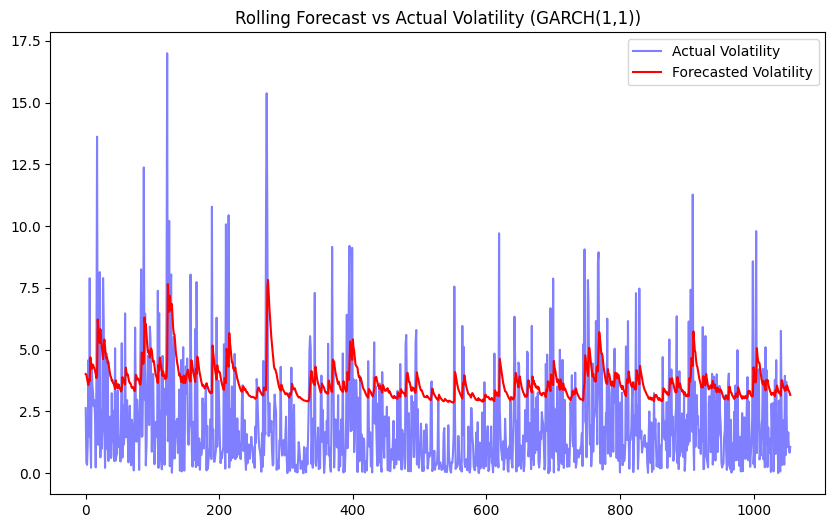

In [168]:
actual_volatility = np.sqrt(test_set_garch**2) 
plt.figure(figsize=(10, 6))
plt.plot(actual_volatility, label="Actual Volatility", color='blue', alpha=0.5)
plt.plot(rolling_predictions, label="Forecasted Volatility", color='red')
plt.title("Rolling Forecast vs Actual Volatility (GARCH(1,1))")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,4))
true, = plt.plot()